In [21]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from segregation.singlegroup import Dissim, SpatialDissim, Isolation, DistanceDecayIsolation
from shapely.geometry import Point, Polygon
import random
import warnings
import imageio
from esda.moran import Moran
from libpysal.weights.contiguity import Queen
import os

# don't show warnings
warnings.filterwarnings("ignore")

def preprocess_shapefile(gdf, city, sample_size):
    gdf = gpd.read_file('./shapefile/buurt_2019_v3.shp')
    gdf = gdf[gdf['GM_NAAM'] == city].reset_index(drop=True)
    # Replace -99999999 with 0
    gdf['P_WEST_AL'].replace(-99999999, 0, inplace=True)
    gdf['P_N_W_AL'].replace(-99999999, 0, inplace=True)
    
    # Calculate population for each group
    gdf['WEST_AL'] = round(gdf['P_WEST_AL'] * gdf['AANT_INW'] / 100)
    gdf['NW_AL'] = round(gdf['P_N_W_AL'] * gdf['AANT_INW'] / 100)
    
    # Update total population
    gdf['AANT_INW'] = gdf['WEST_AL'] + gdf['NW_AL']
    
    # Take sample size
    gdf['WEST_AL'] = round(gdf['WEST_AL'] * sample_size / 100)
    gdf['NW_AL'] = round(gdf['NW_AL'] * sample_size / 100)
    
    # Update total population
    gdf['AANT_INW'] = gdf['WEST_AL'] + gdf['NW_AL']
    
    return gdf


def calculate_percentage(gdf, group_column):
    return (gdf[group_column] / gdf['AANT_INW']) * 100


def relocate_individuals(gdf, toleration_param):
    satisfied = True
    for idx, row in gdf.iterrows():
        west_percentage = calculate_percentage(gdf.loc[[idx]], 'WEST_AL').values[0]
        nw_percentage = calculate_percentage(gdf.loc[[idx]], 'NW_AL').values[0]
        
        #for western population
        if row['WEST_AL'] > 0 and west_percentage < toleration_param:
            #identify neighborhoods with the preferred percentage and already inhabited
            possible_moves = gdf[(calculate_percentage(gdf, 'WEST_AL') >= toleration_param) & (gdf['AANT_INW'] > 0)]
            if not possible_moves.empty:
                # Randomly choose one to move
                move_to_idx = possible_moves.sample(1).index[0]
                gdf.at[move_to_idx, 'WEST_AL'] += row['WEST_AL']
                gdf.at[idx, 'WEST_AL'] = 0
                satisfied = False
        
        #for non-western population
        if row['NW_AL'] > 0 and nw_percentage < toleration_param:
            #identify neighborhoods with the preferred percentage and already inhabited
            possible_moves = gdf[(calculate_percentage(gdf, 'NW_AL') >= toleration_param) & (gdf['AANT_INW'] > 0)]
            if not possible_moves.empty:
                #choose one neighborhood from the list to relocate
                move_to_idx = possible_moves.sample(1).index[0]
                gdf.at[move_to_idx, 'NW_AL'] += row['NW_AL']
                gdf.at[idx, 'NW_AL'] = 0
                satisfied = False
    
    #update total population after relocation
    gdf['AANT_INW'] = gdf['WEST_AL'] + gdf['NW_AL']
    
    return gdf, satisfied


def calculate_segregation_metrics(gdf, toleration_param, city, image_folder):
    rounds = 0
    metrics = {'Dissim': [], 'SpatialDissim': [], 'Isolation': [], 'DistanceDecayIsolation': [], 'Moran_I': []}
    
    while True:
        gdf, satisfied = relocate_individuals(gdf, toleration_param)
        rounds += 1
        
        #save shapefile per iteration
        gdf.to_file(os.path.join(image_folder, f'{city}_it_{rounds}.shp'))
        
        #measure segregation metrics
        dissim = Dissim(gdf, 'NW_AL', 'AANT_INW').statistic
        spatial_dissim = SpatialDissim(gdf, 'NW_AL', 'AANT_INW').statistic
        isolation = Isolation(gdf, 'NW_AL', 'AANT_INW').statistic
        distance_decay_isolation = DistanceDecayIsolation(gdf, 'NW_AL', 'AANT_INW').statistic
        
        #measure moran global autorcoorelation
        y = gdf['NW_AL'].values
        w = Queen.from_dataframe(gdf)
        w.transform = 'r'
        moran = Moran(y, w)
        moran_i = moran.I
        
        metrics['Dissim'].append(dissim)
        metrics['SpatialDissim'].append(spatial_dissim)
        metrics['Isolation'].append(isolation)
        metrics['DistanceDecayIsolation'].append(distance_decay_isolation)
        metrics['Moran_I'].append(moran_i)
        
        #save residential plot per iteration
        plot_population_distribution(gdf, f"{city} ($β ={toleration_param}\% $): \n Iteration {rounds}", os.path.join(image_folder, f'{city}_it_{rounds}.png'))
        
        if satisfied:
            break
    
    return metrics, rounds


def generate_points_within_polygon(polygon, n_points):
    minx, miny, maxx, maxy = polygon.bounds
    points = []

    while len(points) < n_points:
        random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(random_point):
            points.append(random_point)
    
    return points


def plot_population_distribution(gdf, title, save_as):
    fig, ax = plt.subplots()
    
    #plot neighborhood boundaries
    #color non-inhabited neighborhooods with 'mediumaquamarine' 
    gdf[gdf['AANT_INW'] == 0].plot(ax=ax, linewidth=1, edgecolor='#41b6c4', color='mediumaquamarine', alpha=0.5)
    gdf[gdf['AANT_INW'] > 0].plot(ax=ax, linewidth=1, edgecolor='#41b6c4', color='azure', alpha=0.1)
    
    for idx, row in gdf.iterrows():
        #color western population with 'magenta'
        if row['WEST_AL'] > 0:
            west_points = generate_points_within_polygon(row.geometry, int(row['WEST_AL']))
            x_west, y_west = zip(*[(point.x, point.y) for point in west_points])
            ax.scatter(x_west, y_west, color='magenta', alpha=0.3, s=0.1, label='Western' if idx == 0 else "")
        
        #color non-western population with 'orange'
        if row['NW_AL'] > 0:
            nw_points = generate_points_within_polygon(row.geometry, int(row['NW_AL']))
            x_nw, y_nw = zip(*[(point.x, point.y) for point in nw_points])
            ax.scatter(x_nw, y_nw, color='orange', alpha=0.3, s=0.1, label='Non-Western' if idx == 0 else "")
    plt.title(title, fontdict=dict(weight='bold', fontsize=15))
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(save_as, dpi=300)
    plt.show()
    
    
def calculate_original_segregation_metrics(gdf):
    dissim = Dissim(gdf, 'NW_AL', 'AANT_INW').statistic
    spatial_dissim = SpatialDissim(gdf, 'NW_AL', 'AANT_INW').statistic
    isolation = Isolation(gdf, 'NW_AL', 'AANT_INW').statistic
    distance_decay_isolation = DistanceDecayIsolation(gdf, 'NW_AL', 'AANT_INW').statistic
    
    # measure moran global autorcoorelation
    y = gdf['NW_AL'].values
    w = Queen.from_dataframe(gdf)
    w.transform = 'r'
    moran = Moran(y, w)
    moran_i = moran.I
    
    return {
        'Dissim': dissim,
        'SpatialDissim': spatial_dissim,
        'Isolation': isolation,
        'DistanceDecayIsolation': distance_decay_isolation,
        'Moran_I': moran_i
    }


def plot_segregation_metrics(metrics, rounds, original_metrics, save_as):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(range(0, rounds + 1), [original_metrics['Dissim']] + metrics['Dissim'], marker='o', linestyle='-', label='Dissimilarity (D)', color='crimson')
    ax.plot(range(0, rounds + 1), [original_metrics['SpatialDissim']] + metrics['SpatialDissim'], marker='o', linestyle='-', label='Spatial Dissimilarity (SD)', color='darkcyan')
    ax.plot(range(0, rounds + 1), [original_metrics['Isolation']] + metrics['Isolation'], marker='o', linestyle='-', label='Isolation (I)', color='darkgoldenrod')
    ax.plot(range(0, rounds + 1), [original_metrics['DistanceDecayIsolation']] + metrics['DistanceDecayIsolation'], marker='o', linestyle='-', label='Distance Decay Isolation (DDI)', color='olivedrab')
    ax.plot(range(0, rounds + 1), [original_metrics['Moran_I']] + metrics['Moran_I'], marker='o', linestyle='-', label="Moran's I (M)", color='mediumorchid')
    
    plt.xlabel('Iteration', fontdict=dict(weight='bold', fontsize=12))
    plt.ylabel('Segregation Metrics', fontdict=dict(weight='bold', fontsize=12))
    plt.title(f"Segregation Dynamics: \n {city}", fontdict=dict(weight='bold', fontsize=15))
    
    plt.ylim(0, 1.1)
    
    plt.xticks(ticks=range(0, rounds + 1))
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[0] = 'Real'
    ax.set_xticklabels(labels)
    
    sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    plt.legend(ncol=5, loc='upper center', fontsize=8)
    plt.tight_layout()
    plt.savefig(save_as, dpi=300)
    plt.show()

    
def create_gif(image_folder, gif_name, duration=10):
    images = []
    for file_name in sorted(os.listdir(image_folder)):
        if file_name.endswith('.png'):
            file_path = os.path.join(image_folder, file_name)
            images.append(imageio.imread(file_path))
    
    gif_path = os.path.join(image_folder, gif_name)
    imageio.mimsave(gif_path, images, duration=duration)

    
def run_schelling_simulation(file_path, city, sample_size, toleration_param):
    start_time = time.time()
    
    gdf = gpd.read_file(file_path)
    gdf = preprocess_shapefile(gdf, city, sample_size)
    
    image_folder = f"{city}_sim"
    os.makedirs(image_folder, exist_ok=True)
    
    #measure and plot real segregation metrics
    original_metrics = calculate_original_segregation_metrics(gdf)
    
    #plot real distribution
    plot_population_distribution(gdf, f"Real Residential Distribution: \n {city} ($s={sample_size}\% $)", f"{image_folder}/real_pop_{city}.png")
    
    #run simulation
    metrics, rounds = calculate_segregation_metrics(gdf, toleration_param, city, image_folder)
    
    #create animated transition (gif)
    create_gif(image_folder, f"{city}_transition.gif", duration=1.5)  
    
    #plot segregation metrics (real and simulated)
    plot_segregation_metrics(metrics, rounds, original_metrics, f"{image_folder}/segregation_metrics.png")
    
    #show additional infos 
    end_time = time.time()
    
    print(f"Stable state: iteration {rounds}")
    print(f"Sample size: {sample_size}% ")
    print(f"Computation time: {end_time - start_time:.2f} seconds")

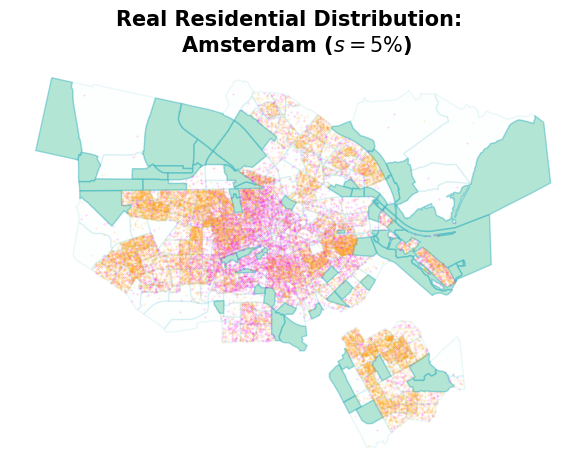

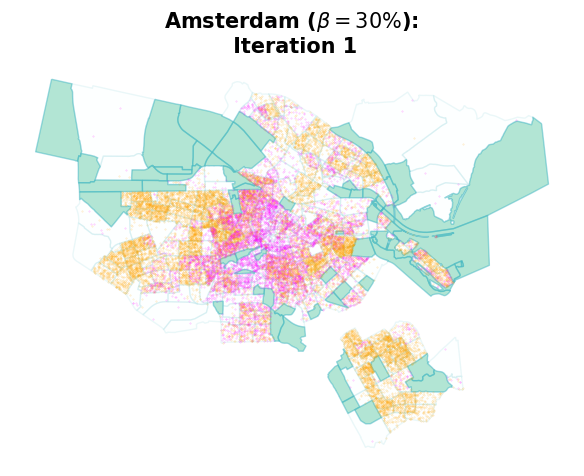

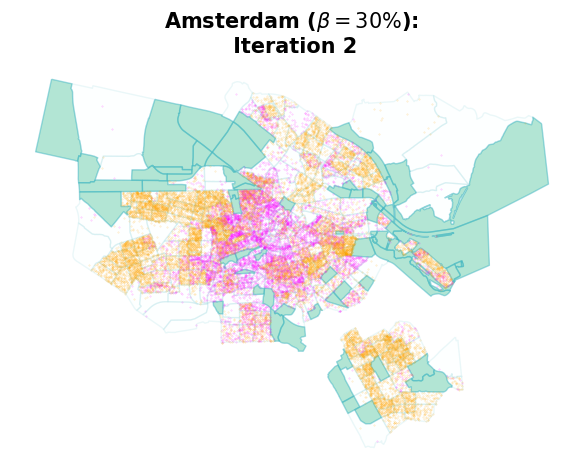

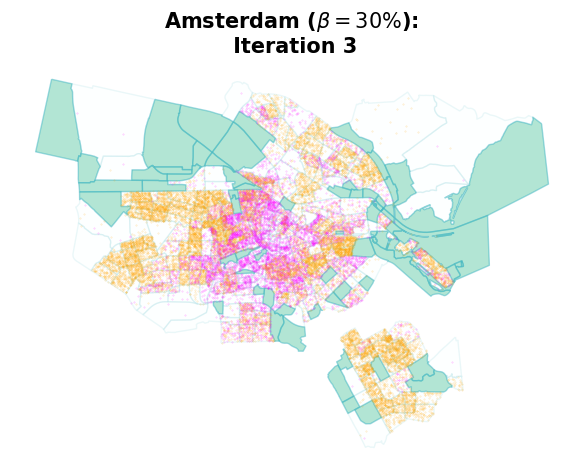

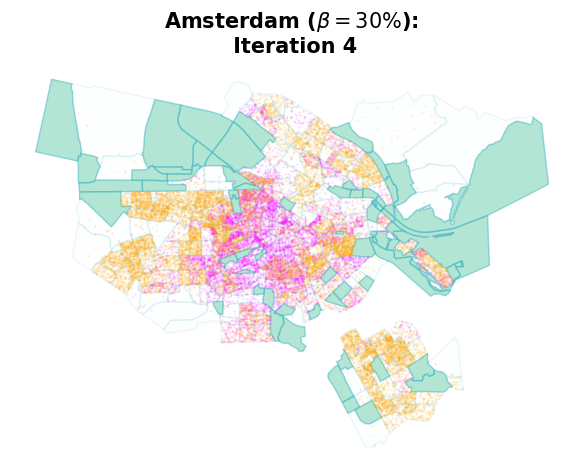

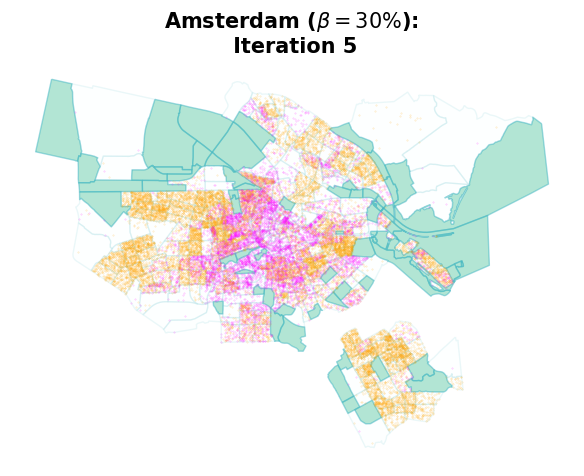

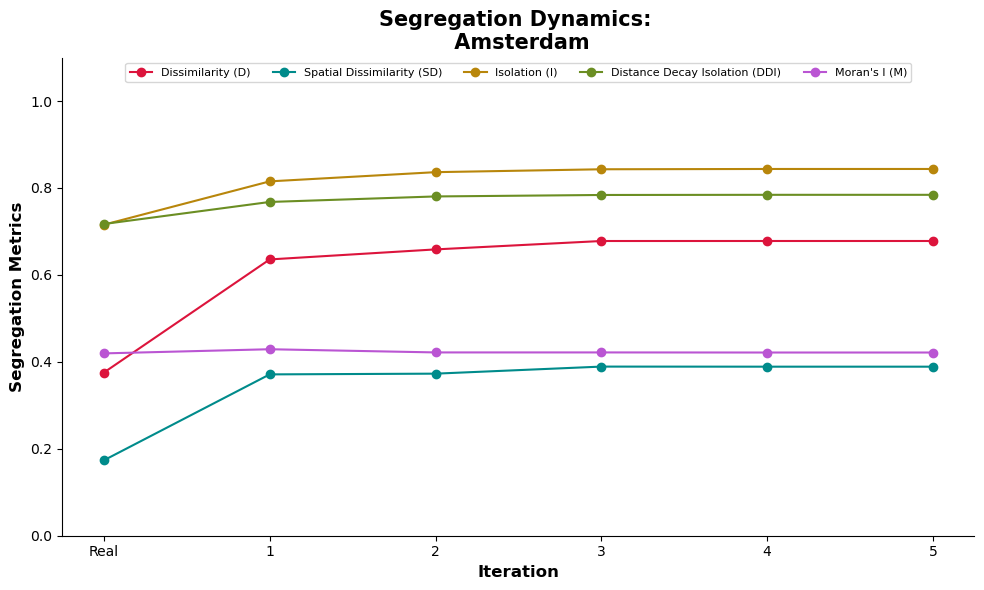

Stable state: iteration 5
Sample size: 5% 
Computation time: 142.59 seconds


In [22]:
#execute commands
file_path = "./shapefile/buurt_2019_v3.shp"
city = 'Amsterdam'
sample_size = 5  # in %
toleration_param = 30  # Toleration parameter as percentage
run_schelling_simulation(file_path, city, sample_size, toleration_param)